# Use MLFlow with the DataRobot API for experimentation and logging

This notebook provides a framework that showcases the integration of MLFlow and Papermill to track machine learning experiments with DataRobot.

This frameworks outline how to:

<ul><li>Use MLFlow with the DataRobot API to track and log ML experiments
<ul><li>Benefit: 
Consistent comparison of results across experiments</li></ul></li>
<li>Use Papermill with the DataRobot API to create artifacts from machine learning experiments to reduce effort needed for collaboration
<ul><li>Benefit: Automation of experiments to avoid errors and reduce manual effort</li></ul></li>
    <li>Execute jupyter notebooks with parameters like Python scripts</li>
<li>Loop through parameter combinations to run multiple projects; build a Model Factory.</li></ul>

<font style="color:blue">This notebook is the experimentation notebook for running individual time series experiments. Papermill is used to recieve parameters from the main notebook (<code>orchestration_notebook.ipynb</code>) and run a copy of this notebook for each combination of the parameters.</font>
    
<font style="color:blue">The experiment notebook doesn't require any updates as the parameters are passed from the main notebook. However, this notebook will be updated for different modeling approach like AutoML, Unsupervised learning, etc.</font>

## Setup

### Bind inputs

In [28]:
FDW = 35
KIA = False
UUID = str("bcf6c090-1899-11ed-a7a1-f018981f05a4")
ACC_OPT = False
SRCH_INT = False
SEGMENTED = False
MODE = "quick"
TRAINING_DATA = "./DR_Demo_Sales_Multiseries_training (1).xlsx"
DATE_COL = "Date"
TRAINING_STOP_DATE = "01-06-2014"
TRAINING_STOP_DATE_FORMAT = "%d-%m-%Y"
DR_AUTH_YAML_FILE = "~/.config/datarobot/drconfig.yaml"
TARGET_COL = "Sales"
KIA_COLS = ["Marketing", "Near_Xmas", "Near_BlackFriday", "Holiday", "DestinationEvent"]
IS_MULTISERIES = True
MULTISERIES_COLS = ["Store"]
REFERENCE_NOTEBOOK = "./experiments_bkup/experiment_d666bc12-7602-11ed-99f4-f018981f05a4.ipynb"

### Import libraries

In [2]:
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from permetrics.regression import (  # permetrics library for simplifying metric calculation
    RegressionMetric,
)

### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [8]:
# Authenticate in to your DataRobot instance
import datarobot as dr
import yaml

cred_file = open(DR_AUTH_YAML_FILE, "r")
credentials = yaml.safe_load(cred_file)

DATAROBOT_API_TOKEN = credentials["token"]
DATAROBOT_ENDPOINT = credentials["endpoint"]

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="AIA-AE-MLF-1",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

Project(Repex_bcf6c090-1899-11ed-a7a1-f018981f05a4)

### Import training data

In [3]:
df = pd.DataFrame()
if TRAINING_DATA.find(".csv") != -1:
    df = pd.read_csv(TRAINING_DATA, parse_dates=[DATE_COL])
elif TRAINING_DATA.find(".xls") != -1:
    df = pd.read_excel(TRAINING_DATA, parse_dates=[DATE_COL])
else:
    df = pd.DataFrame()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140 entries, 0 to 7139
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Store             7140 non-null   object        
 1   Date              7140 non-null   datetime64[ns]
 2   Sales             7140 non-null   int64         
 3   Store_Size        7140 non-null   int64         
 4   Num_Employees     7140 non-null   int64         
 5   Returns_Pct       7140 non-null   float64       
 6   Num_Customers     7140 non-null   int64         
 7   Pct_On_Sale       7130 non-null   float64       
 8   Marketing         7140 non-null   object        
 9   Near_Xmas         7140 non-null   int64         
 10  Near_BlackFriday  7140 non-null   int64         
 11  Holiday           7140 non-null   object        
 12  DestinationEvent  7140 non-null   object        
 13  Pct_Promotional   7140 non-null   float64       
 14  Econ_ChangeGDP    80 non

### Private holdout

Set a cutoff date for private holdout. This is necessary to enable the same holdout for all experiments irrespective of feature derivation windows and forecast windows. 

In [5]:
training_stop_date = pd.to_datetime(TRAINING_STOP_DATE, format=TRAINING_STOP_DATE_FORMAT)

In [6]:
df_train = df[df[DATE_COL] < training_stop_date]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7125
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Store             7000 non-null   object        
 1   Date              7000 non-null   datetime64[ns]
 2   Sales             7000 non-null   int64         
 3   Store_Size        7000 non-null   int64         
 4   Num_Employees     7000 non-null   int64         
 5   Returns_Pct       7000 non-null   float64       
 6   Num_Customers     7000 non-null   int64         
 7   Pct_On_Sale       6990 non-null   float64       
 8   Marketing         7000 non-null   object        
 9   Near_Xmas         7000 non-null   int64         
 10  Near_BlackFriday  7000 non-null   int64         
 11  Holiday           7000 non-null   object        
 12  DestinationEvent  7000 non-null   object        
 13  Pct_Promotional   7000 non-null   float64       
 14  Econ_ChangeGDP    80 non

## Modeling

### Create a DataRobot project

In [8]:
# Upload data and create a new DataRobot project
project = dr.Project.create(df_train, project_name="Repex_" + UUID)
project

Project(Repex_bcf6c090-1899-11ed-a7a1-f018981f05a4)

### Configure project settings

Set up time series settings for the newly created project.

In [9]:
known_in_advance = KIA_COLS
feature_settings = [
    dr.FeatureSettings(feat_name, known_in_advance=True) for feat_name in known_in_advance
]

time_partition = dr.DatetimePartitioningSpecification(
    datetime_partition_column=DATE_COL,
    use_time_series=True,
    feature_derivation_window_start=-1 * FDW,
    feature_derivation_window_end=0,
    forecast_window_start=1,
    forecast_window_end=14,
)

if KIA:
    time_partition.feature_settings = feature_settings

if IS_MULTISERIES:
    time_partition.multiseries_id_columns = MULTISERIES_COLS

advanced_options = dr.AdvancedOptions(
    accuracy_optimized_mb=ACC_OPT, autopilot_with_feature_discovery=SRCH_INT
)

### Initiate Autopilot

After creating settings objects, Autopilot is started using the `analyze_and_model` function.

In [10]:
project.analyze_and_model(
    target=TARGET_COL,
    partitioning_method=time_partition,
    max_wait=3600,
    worker_count=-1,
    advanced_options=advanced_options,
    mode=MODE,
)
print(project.get_uri())
project.wait_for_autopilot()

https://app.datarobot.com/projects/63902ec8c32fb2b2077f5da1/models
In progress: 19, queued: 2 (waited: 0s)
In progress: 19, queued: 2 (waited: 1s)
In progress: 19, queued: 2 (waited: 3s)
In progress: 19, queued: 2 (waited: 5s)
In progress: 19, queued: 2 (waited: 7s)
In progress: 19, queued: 2 (waited: 10s)
In progress: 19, queued: 2 (waited: 14s)
In progress: 19, queued: 2 (waited: 21s)
In progress: 19, queued: 2 (waited: 35s)
In progress: 19, queued: 2 (waited: 56s)
In progress: 19, queued: 2 (waited: 78s)
In progress: 19, queued: 0 (waited: 99s)
In progress: 12, queued: 0 (waited: 120s)
In progress: 9, queued: 0 (waited: 141s)
In progress: 6, queued: 0 (waited: 162s)
In progress: 4, queued: 0 (waited: 184s)
In progress: 2, queued: 0 (waited: 205s)
In progress: 1, queued: 0 (waited: 226s)
In progress: 0, queued: 0 (waited: 247s)
In progress: 4, queued: 0 (waited: 268s)
In progress: 4, queued: 0 (waited: 289s)
In progress: 2, queued: 0 (waited: 310s)
In progress: 2, queued: 0 (waited: 

### Get the recommended model

After Autopilot completes, get the recommended model from DataRobot

In [11]:
recommendation = dr.ModelRecommendation.get(project.id)
recommended_model = recommendation.get_model()
print(recommended_model)

DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping (learning rate =0.3)')


### Performance validation

Create the private holdout from original dataset and get predictions from DataRobot recommended model. Once predictions are available, the predictions are compared to actuals using regression metrics.

In [12]:
dataset = project.upload_dataset(df, forecast_point=training_stop_date)
pred_job = recommended_model.request_predictions(dataset_id=dataset.id)
preds = pred_job.get_result_when_complete()

In [14]:
preds["timestamp"] = pd.to_datetime(preds["timestamp"], utc=True)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], utc=True)
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   row_id             130 non-null    int64              
 1   prediction         130 non-null    float64            
 2   forecast_distance  130 non-null    int64              
 3   forecast_point     130 non-null    object             
 4   timestamp          130 non-null    datetime64[ns, UTC]
 5   series_id          130 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(2), object(2)
memory usage: 6.2+ KB


In [15]:
if IS_MULTISERIES:
    df_comparison = df[MULTISERIES_COLS + [DATE_COL, TARGET_COL]].merge(
        preds[["prediction", "timestamp", "series_id"]],
        left_on=MULTISERIES_COLS + [DATE_COL],
        right_on=["series_id", "timestamp"],
    )
else:
    df_comparison = df[[DATE_COL, TARGET_COL]].merge(
        preds[["prediction", "timestamp"]], left_on=[DATE_COL], right_on=["timestamp"]
    )
assert df_comparison.shape[0] == preds.shape[0]
df_comparison.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 0 to 129
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Store       130 non-null    object             
 1   Date        130 non-null    datetime64[ns, UTC]
 2   Sales       130 non-null    int64              
 3   prediction  130 non-null    float64            
 4   timestamp   130 non-null    datetime64[ns, UTC]
 5   series_id   130 non-null    object             
dtypes: datetime64[ns, UTC](2), float64(1), int64(1), object(2)
memory usage: 7.1+ KB


Plotting actuals vs predicted for visual verification

(array([16224., 16226., 16228., 16230., 16232., 16234.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

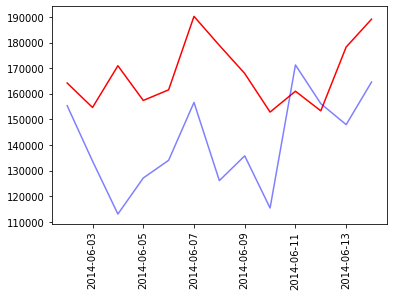

In [24]:
if not IS_MULTISERIES:
    plt.plot(
        df_comparison["timestamp"],
        df_comparison["prediction"],
        label="Prediction",
        color="red",
    )
    plt.plot(
        df_comparison["timestamp"],
        df_comparison["Sales"],
        label="Actuals",
        color="blue",
        alpha=0.5,
    )
else:
    df_viz = df_comparison[df_comparison["series_id"] == df_comparison.series_id.unique()[0]]
    plt.plot(df_viz["timestamp"], df_viz["prediction"], label="Prediction", color="red")
    plt.plot(df_viz["timestamp"], df_viz["Sales"], label="Actuals", color="blue", alpha=0.5)
plt.xticks(rotation=90)

In [17]:
# Validate experiment performance
evaluator = RegressionMetric(df_comparison[TARGET_COL].values, df_comparison["prediction"].values)

### Tracking and logging experiments

Log experiment metrics and parameters for display and comparison on the MLFlow UI.

In [30]:
with mlflow.start_run():
    mlflow.log_param("Project URL", project.get_uri())  # URL for DataRobot Project
    mlflow.log_param(
        "Notebook Location", REFERENCE_NOTEBOOK
    )  # location of final notebook for reference
    mlflow.log_param("Feature Derivation Window", FDW)  # feature derivation used
    mlflow.log_param("Enabled Known In Advance features", KIA)  # known in advance setting
    mlflow.log_param("Ran Accuracy Optimized BPs", ACC_OPT)  # accuracy optimized setting
    mlflow.log_param(
        "Enabled Search Interactions option", SRCH_INT
    )  # search for interactions setting
    mlflow.log_param("Autopilot Mode", MODE)  # autopilot mode

    mlflow.log_artifact(REFERENCE_NOTEBOOK)  # location of final notebook for reference

    # logging model performance metrics
    mlflow.log_metric("MASE", evaluator.MASE())
    mlflow.log_metric("MAPE", evaluator.MAPE())
    mlflow.log_metric("RMSE", evaluator.RMSE())
    mlflow.log_metric("MAE", evaluator.MAE())
    mlflow.log_metric("R2", evaluator.R2())
    mlflow.log_metric("Support", preds.shape[0])